<a href="https://colab.research.google.com/github/MaryVickk/Inception-LSTM/blob/main/70epocasDeusBomeInception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bibliotecas básicas
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm  # Biblioteca de barras de progresso para Jupyter Notebook

# Estrutura de aprendizado profundo para construção e treinamento de modelos
import tensorflow as tf
## Modelo pré-treinado para extração de características de imagem
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Classe Tokenizer para tokenização de legendas
from tensorflow.keras.preprocessing.text import Tokenizer

## Função para preencher sequências com um comprimento específico
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Classe para definir modelos Keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# Para verificar a pontuação
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Carregar o modelo Inception V3
model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))

# Reestruturando o modelo para remover a última camada de classificação (acesso aos recursos de saída do modelo).
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Imprimindo o resumo do modelo
print(model.summary())

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [ ]:
# Inicializar um dicionário vazio para armazenar as características das imagens
image_features = {}

# Dataset de todas as imagens
img_dir = os.path.join('/content/drive/MyDrive/TCC/Images')

# Loop através de cada imagem no diretório
for img_name in tqdm(os.listdir(img_dir)):
    # Carregar a imagem do arquivo
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(299, 299))
    # Converter pixels da imagem para um array numpy
    image = img_to_array(image)
    # Redimensionar os dados para o modelo
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Pré-processar a imagem para InceptionV3
    image = preprocess_input(image)
    # Extrair características usando o modelo pré-treinado InceptionV3
    image_feature = model.predict(image, verbose=0)
    # Obter o ID da imagem removendo a extensão do arquivo
    image_id = img_name.split('.')[0]
    # Armazenar a característica extraída no dicionário com o ID da imagem como chave
    image_features[image_id] = image_feature

  0%|          | 0/8121 [00:00<?, ?it/s]

In [ ]:
# Armazena os recursos da imagem no pickle
pickle.dump(image_features, open(os.path.join('img_features.pkl'), 'wb'))

In [ ]:
# Carrega recursos do arquivo pickle
pickle_file_path = os.path.join('img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [ ]:
with open(os.path.join('/content/drive/MyDrive/TCC/captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# criar mapeamento de imagem para legendas
image_to_captions_mapping = defaultdict(list)

# Linhas de processo de captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Dividir a linha por vírgula(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remover extensão do ID da imagem
    image_id = image_id.split('.')[0]
    # Converter lista de legendas em string
    caption = " ".join(captions)
    # Armazena a legenda usando defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Imprime o número total de legendas
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Número total de legendas:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Número total de legendas: 40455


In [ ]:
# Função para processar as legendas
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Escolha uma legenda de cada vez
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remover caracteres não alfabéticos
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remover espaços extras
            caption = caption.replace('\s+', ' ')
            # Adicione tokens de início e fim exclusivos à legenda
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# antes do pré-processamento do texto
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [ ]:
# pré-processar o texto
clean(image_to_captions_mapping)

In [ ]:
# após pré-processamento de texto
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [ ]:
#Criando uma lista de todas as legendas
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [ ]:
all_captions[:20]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

In [ ]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Salva o tokenizer
with open('/content/drive/MyDrive/TCC/Flickr8k.token.txt', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Carrega o tokenizer
with open('/content/drive/MyDrive/TCC/Flickr8k.token.txt', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [ ]:
# Calcular o comprimento máximo da legenda
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Imprimir os resultados
print("Tamanho do vocaabulário", vocab_size)
print("Comprimento máximo da legenda:", max_caption_length)

Tamanho do vocaabulário 8768
Comprimento máximo da legenda: 34


In [ ]:
# Criando uma lista de IDs de imagem
image_ids = list(image_to_captions_mapping.keys())
# Dividindo em conjuntos de treinamento e teste
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
from tensorflow.data import Dataset

In [ ]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0])  # Características da imagem
                    X2_batch.append(in_seq)  # Sequência de entrada
                    y_batch.append(out_seq)  # Sequência de saída

                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch_np = np.array(X1_batch)
                        X2_batch_np = np.array(X2_batch)
                        y_batch_np = np.array(y_batch)

                        yield (X1_batch_np, X2_batch_np), y_batch_np

                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [ ]:
from tensorflow.keras.layers import BatchNormalization

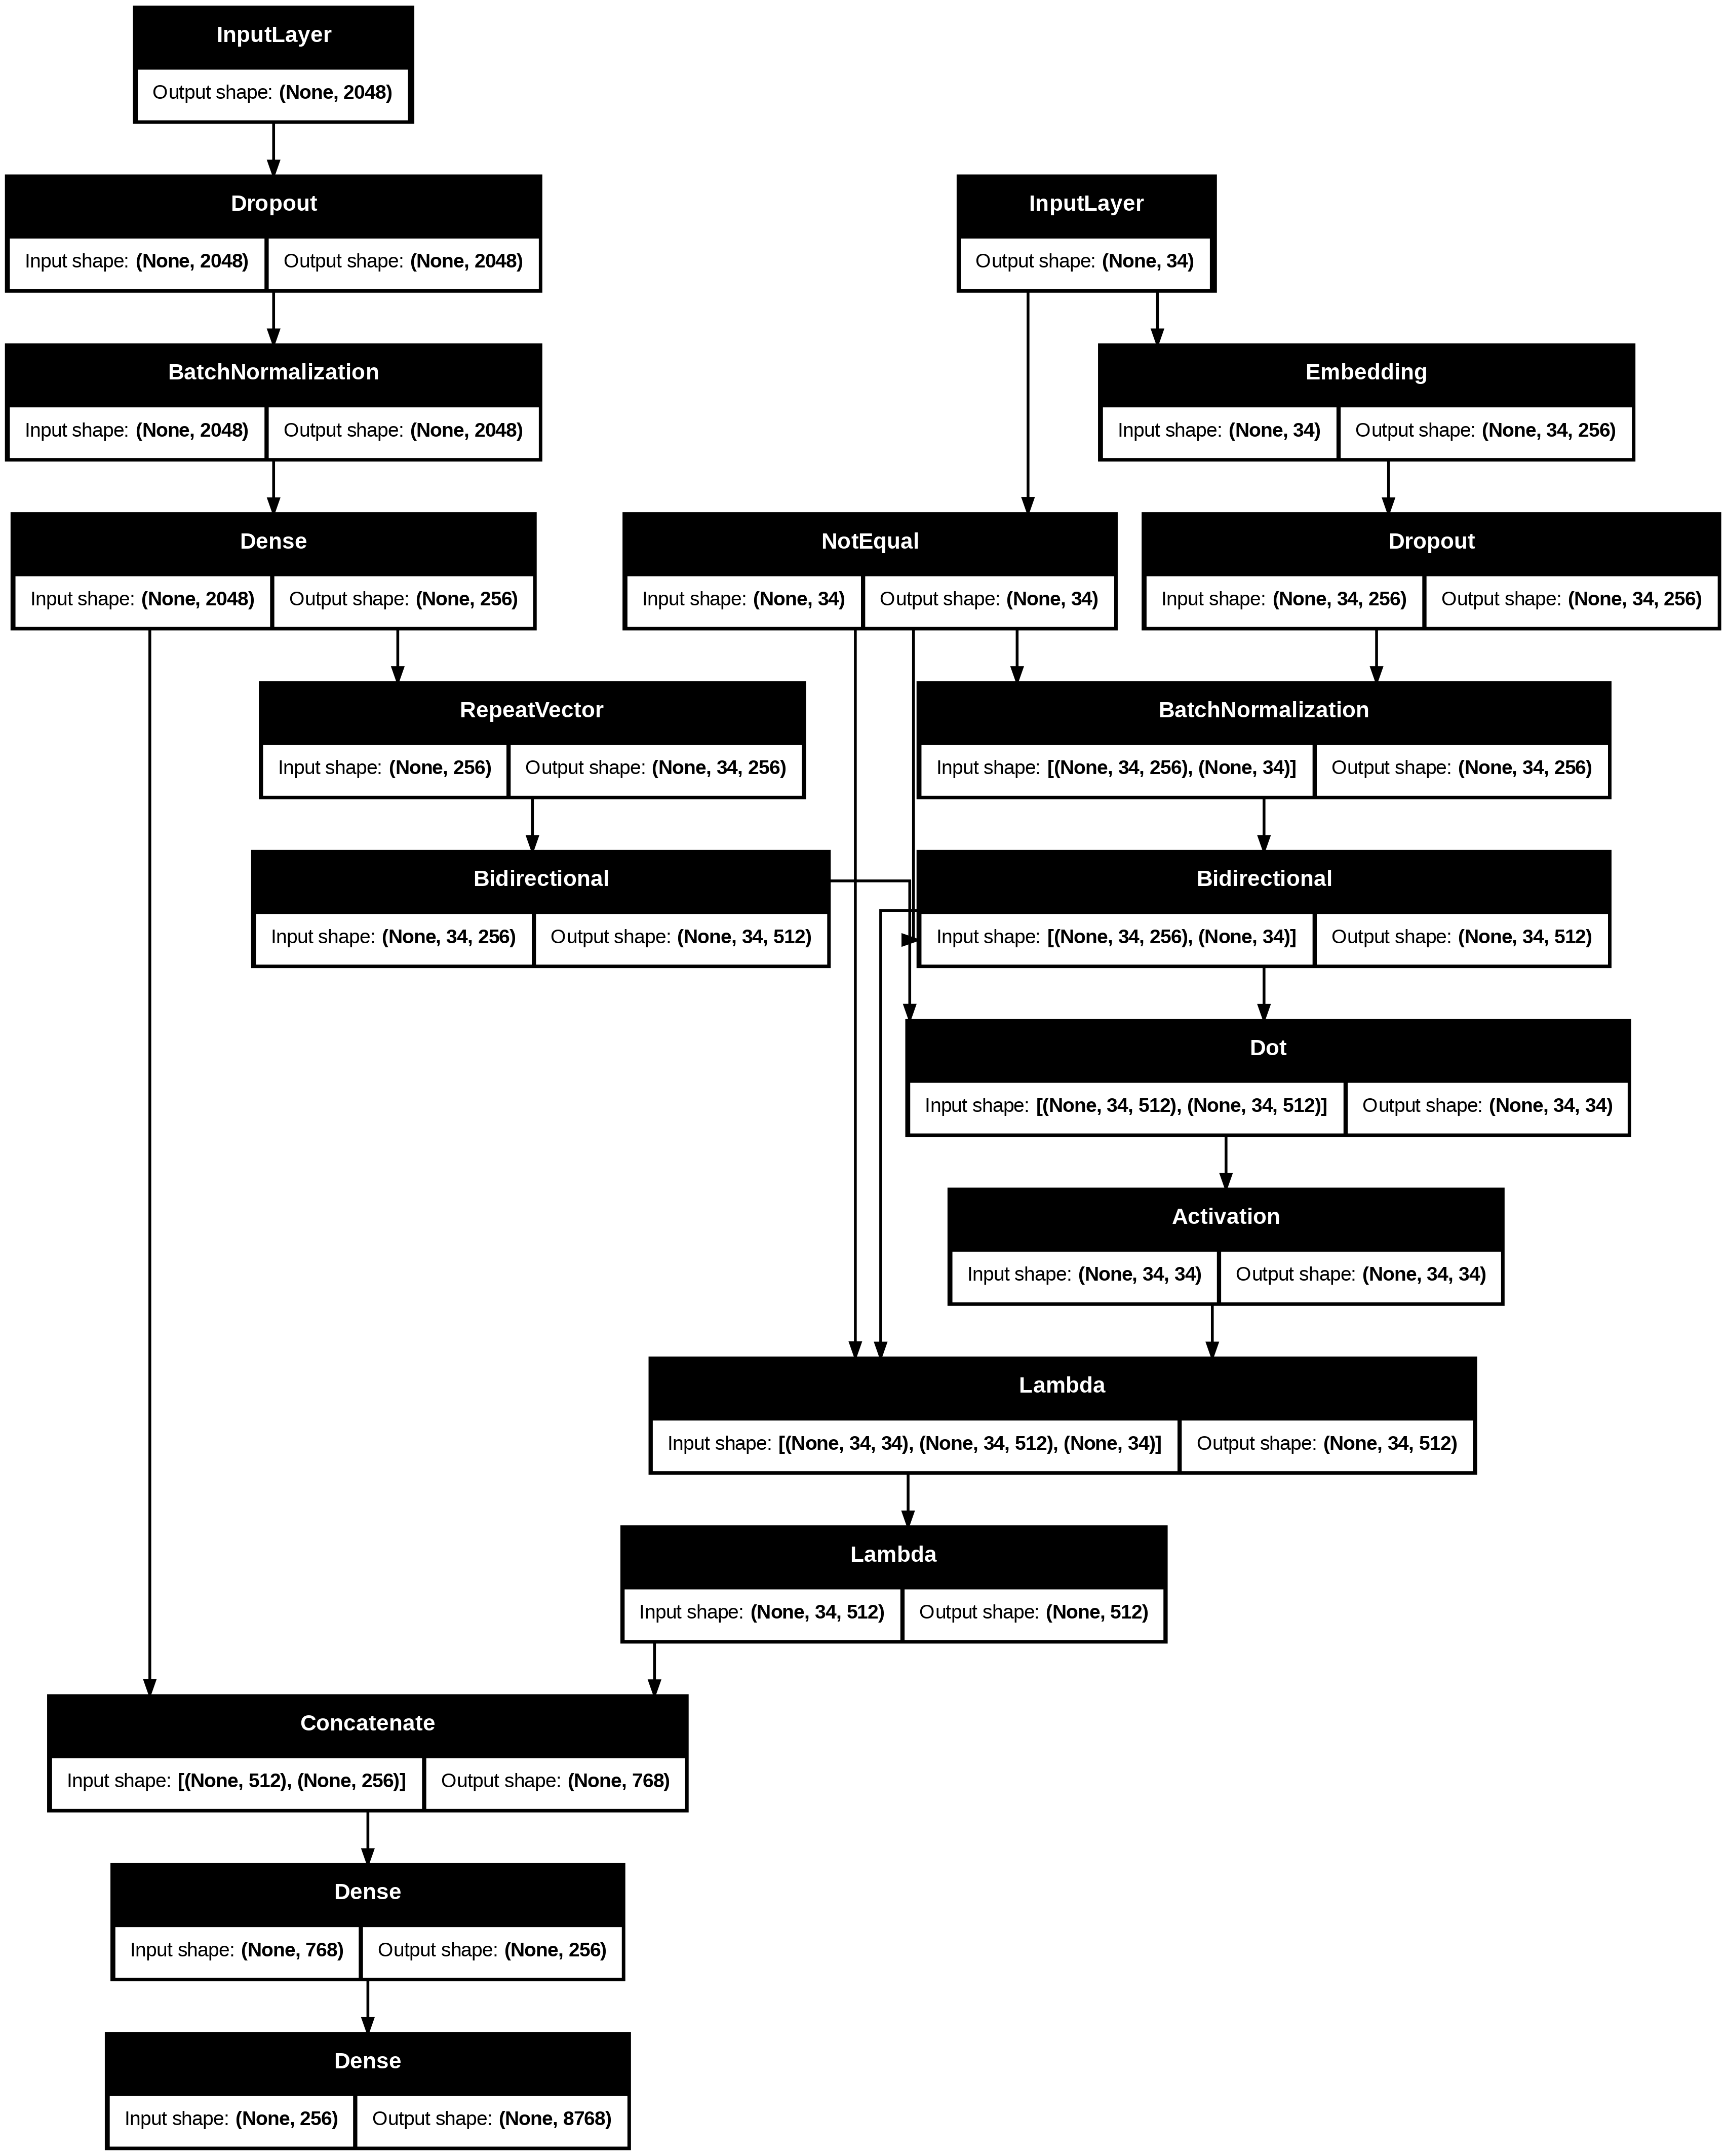

In [ ]:
# Modelo de CNN
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.1)(inputs1)
fe1 = BatchNormalization()(fe1)  # Adicionei aqui pra testar
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Camadas de recursos de sequência
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.1)(se1)
se2 = BatchNormalization()(se2)  # Adicionei aqui pra testar
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Aplicar mecanismo de atenção usando produto escalar
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calcular pontuações de atenção

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Aplicar pontuações de atenção a embeddings de sequência
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Some as sequências de incorporação atendidas ao longo do eixo do tempo
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Modelo decodificador
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Crie o modelo
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualizar o modelo
plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Configurar o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:
# Número de épocas e tamanho do lote
epochs = 70
batch_size = 512

# Calcula os passos por época com base no número de lotes em uma época
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

# Configuração dos geradores de dados
train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

# Treinamento do modelo
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[early_stopping]  # Adicionando o Early Stopping
)

Epoch 1/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 8.1179 - val_loss: 6.7094
Epoch 2/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 5.8477 - val_loss: 6.8905
Epoch 3/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - loss: 5.7014 - val_loss: 6.3360
Epoch 4/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - loss: 5.4554 - val_loss: 6.8258
Epoch 5/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - loss: 5.2461 - val_loss: 7.0397
Epoch 6/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - loss: 5.2142 - val_loss: 6.9163
Epoch 7/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - loss: 4.9965 - val_loss: 6.7302
Epoch 8/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - loss: 4.8277 - val_loss: 6.6434
Epoch 9/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - loss: 4.7771 - val_loss: 6.6162
Epoch 10/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - loss: 4.5524 - val_loss: 6.1389
Epoch 11/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - loss: 4.2523 - val_loss: 6.0564
Epoch 12/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - loss: 4.5382 - val_l

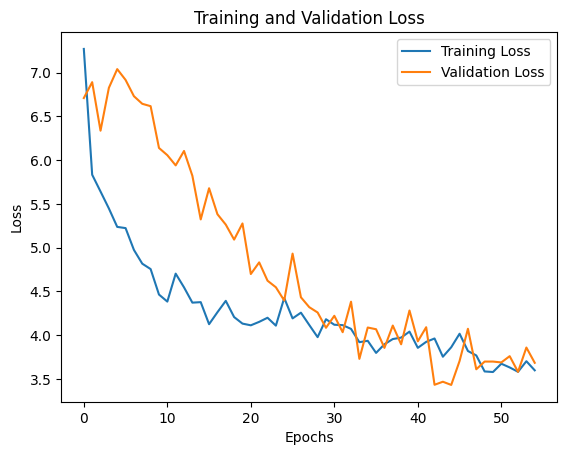

In [ ]:
# Plotando a perda de treinamento e validação
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Save the model
# model.save(OUTPUT_DIR+'/mymodel.h5')
model.save('/content/drive/MyDrive/TCC/mymodel.keras')

In [ ]:
#Captions Generation
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Inicializar a sequência de legendas
    caption = 'startseq'

    # Gerar a legenda
    for _ in range(max_caption_length):
        # Converta a legenda atual em uma sequência de índices de token
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Preencha a sequência para corresponder ao comprimento máximo da legenda
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        #Preveja a distribuição de probabilidade da próxima palavra
        yhat = model.predict([image_features, sequence], verbose=0)
        # Obtenha o índice com a maior probabilidade
        predicted_index = np.argmax(yhat)
        # Converter o índice em uma palavra
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Adicione a palavra prevista à legenda
        caption += " " + predicted_word

        # Pare se a palavra for Nenhum ou se a tag de sequência final for encontrada
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [ ]:
# Inicializar listas para armazenar legendas reais e previstas
actual_captions_list = []
predicted_captions_list = []

# Percorrer os dados de teste
for key in tqdm(test):
    # Obtenha legendas reais para a imagem atual
    actual_captions = image_to_captions_mapping[key]
    # Preveja a legenda da imagem usando o modelo
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Dividir legendas reais em palavras
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Dividir legenda prevista em palavras
    predicted_caption_words = predicted_caption.split()

    # Adicionar às listas
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calcular pontuação da métrica BLEU
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1/3, 1/3, 1/3, 0)))
print("BLEU-4: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25)))

NameError: name 'tqdm' is not defined

In [ ]:
!pip install nltk

import nltk
nltk.download('wordnet')  # Para sinônimos e stemming
nltk.download('omw-1.4')  # Para acesso ao WordNet
from nltk.translate.meteor_score import meteor_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Inicialize listas para armazenar as pontuações METEOR
meteor_scores = []

# Loop através dos dados de teste
for key in tqdm(test):
    # Obtenha as legendas reais para a imagem atual
    actual_captions = image_to_captions_mapping[key]
    # Preveja a legenda para a imagem usando o modelo
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Limpeza e tokenização das legendas reais e previstas
    actual_captions_tokenized = [caption.split()[1:-1] for caption in actual_captions]  # Remove 'startseq' e 'endseq'
    predicted_caption_tokenized = predicted_caption.split()[1:-1]  # Remove 'startseq' e 'endseq'

    # Calcule o METEOR para cada par de legenda real e prevista
    for actual_caption in actual_captions_tokenized:
        meteor = meteor_score([actual_caption], predicted_caption_tokenized)
        meteor_scores.append(meteor)

# Calcula a média das pontuações METEOR
average_meteor = np.mean(meteor_scores)
print(f"Média da pontuação METEOR: {average_meteor:.4f}")

  0%|          | 0/810 [00:00<?, ?it/s]

Média da pontuação METEOR: 0.1582


In [ ]:
# Clone o repositório do pycocoevalcap
!git clone https://github.com/salaniz/pycocoevalcap.git

# Instale a biblioteca com pip
!pip install -e pycocoevalcap

from pycocoevalcap.cider.cider import Cider

# Função para calcular a pontuação CIDEr
def calculate_cider_score(actual_captions_list, predicted_captions_list):
    # Cria dicionários de referências e hipóteses
    references = {i: [" ".join(caption) for caption in captions] for i, captions in enumerate(actual_captions_list)}
    hypotheses = {i: [" ".join(caption)] for i, caption in enumerate(predicted_captions_list)}

    # Inicializa o avaliador CIDEr
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(references, hypotheses)

    return cider_score

# Calcula a pontuação CIDEr
cider_score = calculate_cider_score(actual_captions_list, predicted_captions_list)

print(f"Pontuação CIDEr: {cider_score:.4f}")

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 33.44 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Obtaining file:///content/pycocoevalcap
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pycocoevalcap
Pontuação CIDEr: 0.3239


In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

# Função para calcular as pontuações ROUGE
def calculate_rouge_scores(actual_captions_list, predicted_captions_list):
    # Inicializa o avaliador ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for actual_captions, predicted_caption in zip(actual_captions_list, predicted_captions_list):
        # Calcula a pontuação ROUGE para cada par de legenda real e prevista
        scores = scorer.score(' '.join(actual_captions[0]), ' '.join(predicted_caption))
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calcula a média das pontuações para cada métrica ROUGE
    rouge1_mean = np.mean(rouge1_scores)
    rouge2_mean = np.mean(rouge2_scores)
    rougeL_mean = np.mean(rougeL_scores)

    return rouge1_mean, rouge2_mean, rougeL_mean

# Calcula as pontuações ROUGE
rouge1, rouge2, rougeL = calculate_rouge_scores(actual_captions_list, predicted_captions_list)
print(f"ROUGE-1: {rouge1:.4f}")
print(f"ROUGE-2: {rouge2:.4f}")
print(f"ROUGE-L: {rougeL:.4f}")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9fc658450ff27d43333bcb841aa65d81ee4f2f668145817451ee0aa25287b6f7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
ROUGE-1: 0.3758
ROUGE-2: 0.0849
ROUGE-L: 0.3673


In [ ]:
#predicting caption for images

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/drive/MyDrive/TCC/Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]

    print('---------------------Legendas Atuais---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)

    print('--------------------Legenda Prevista--------------------')
    print(y_pred)

    # Calculate BLEU score
    references = [caption.split() for caption in captions]  # Tokenize the actual captions
    candidate = y_pred.split()  # Tokenize the predicted caption

    # Smoothing function to handle cases with low n-grams
    smoothing = SmoothingFunction().method1

    bleu_1 = sentence_bleu(references, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smoothing)

    print('--------------------BLEU Scores--------------------')
    print(f'BLEU-1: {bleu_1:.4f}')

    plt.imshow(image)

---------------------Legendas Atuais---------------------
startseq black dog leaps for ball held by man endseq
startseq man is playing with black and white dog endseq
startseq man wearing glasses and his black and white dog wearing black collar are playing with tennis ball endseq
startseq man holding ball while dog jumps up for it endseq
startseq man with dog who is jumping to catch tennis ball endseq
--------------------Legenda Prevista--------------------
startseq man in black shirt and black and white dog are playing with ball in the grass endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.6832


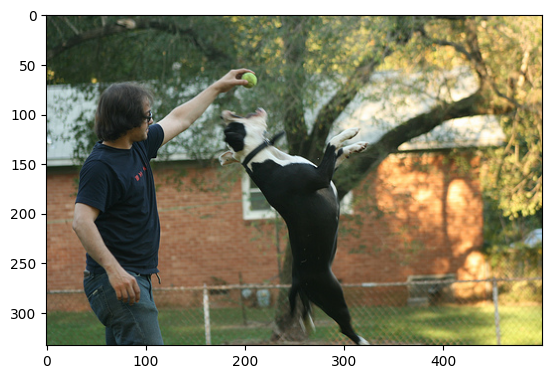

In [ ]:
generate_caption("2944836001_b38b516286.jpg")


---------------------Legendas Atuais---------------------
startseq black and tan dog is running with white and gray dog along dirt endseq
startseq the two dogs are running into the woods endseq
startseq two dogs run down dirt path in the forest endseq
startseq two dogs running away from the camera in the woods endseq
startseq two dogs run on dirt area near forest endseq
--------------------Legenda Prevista--------------------
startseq two dogs are playing in the grass endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.6960


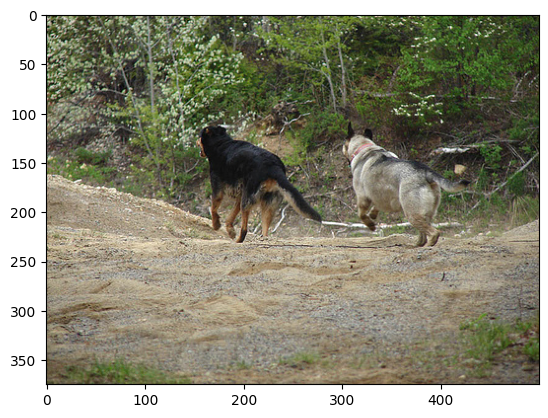

In [ ]:
generate_caption("3593392955_a4125087f6.jpg")


---------------------Legendas Atuais---------------------
startseq few younger boys play around fountain endseq
startseq group of people gather around large fountain endseq
startseq three boys play around fountain in an office building courtyard endseq
startseq three kids are playing at fountain in front of building endseq
startseq three kids playing around fountain endseq
--------------------Legenda Prevista--------------------
startseq two people are playing in the water endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.6667


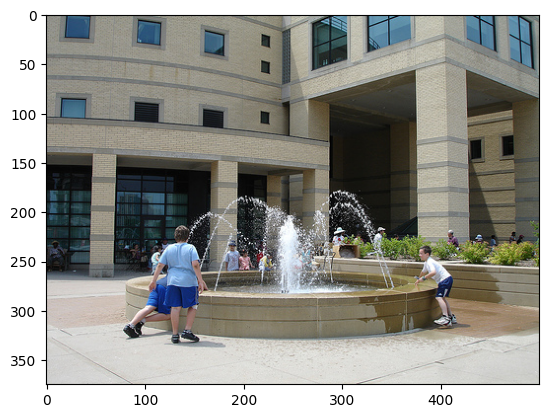

In [ ]:
generate_caption("180094434_b0f244832d.jpg")


---------------------Legendas Atuais---------------------
startseq blond dog runs down flight of stairs to the backyard endseq
startseq dog jumps off the stairs endseq
startseq tan dog runs down wooden staircase to the green grass endseq
startseq yellow dog is jumping across grassy yard in front of wooden deck endseq
startseq yellow dog jumping off of porch endseq
--------------------Legenda Prevista--------------------
startseq brown dog is running through the grass endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.6667


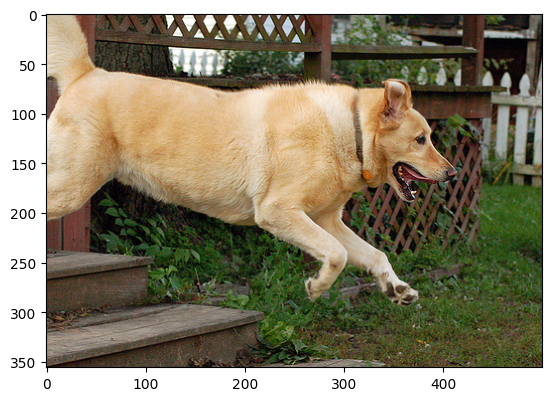

In [ ]:
generate_caption("246055693_ccb69ac5c6.jpg")

---------------------Legendas Atuais---------------------
startseq helmeted man jumping off rock on mountain bike endseq
startseq man jumping on his bmx with another bmxer watching endseq
startseq mountain biker is jumping his bike over rock as another cyclist stands on the trail watching endseq
startseq person taking jump off rock on dirt bike endseq
startseq the bike rider jumps off rock endseq
--------------------Legenda Prevista--------------------
startseq dirt biker is riding bike on dirt path endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.7000


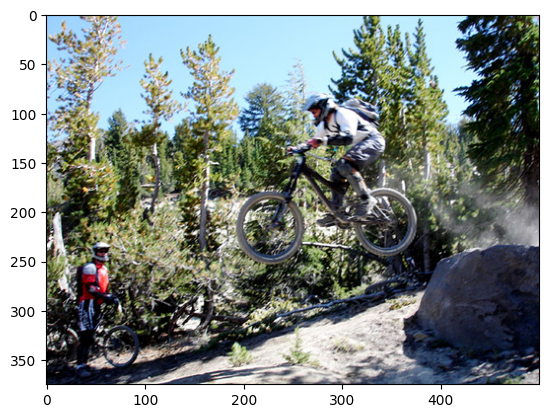

In [ ]:
generate_caption("136552115_6dc3e7231c.jpg")

---------------------Legendas Atuais---------------------
startseq man wearing red helmet jumps up while riding skateboard endseq
startseq young man wearing red jacket performs jump on red skateboard endseq
startseq the helmeted boy is doing stunt on skateboard endseq
startseq the young man is skateboarding at skate park endseq
startseq young man is performing trick on skateboard in park endseq
--------------------Legenda Prevista--------------------
startseq boy in red shirt is jumping off ramp endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.6000


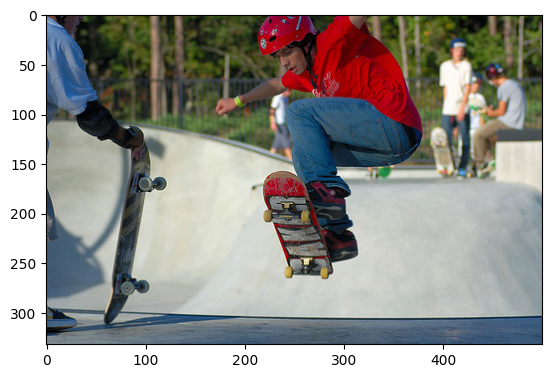

In [ ]:
generate_caption("2207244634_1db1a1890b.jpg")

---------------------Legendas Atuais---------------------
startseq kite surfer is doing flip over the waves endseq
startseq man jumps over wave on his surfboard endseq
startseq person on parasail jumps off wave endseq
startseq silver craft rides the waves endseq
startseq windsurfer angles over wave endseq
--------------------Legenda Prevista--------------------
startseq person is jumping over the air endseq
--------------------BLEU Scores--------------------
BLEU-1: 0.7500


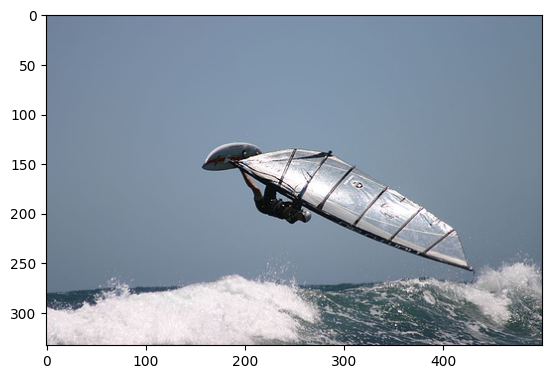

In [ ]:
generate_caption("70995350_75d0698839.jpg")